# Lung Cancer Detection using Convolutional Neural Network

### Notes:
Data can be found at [this link](https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images?resource=download&select=lung_colon_image_set)


To run this model, please place the provided lung_colon_image_set.zip file in the Content folder alongside, but not in, the sample_data folder.


In order to increase the efficiency of which this model runs, and to avoid the epochs taking multiple hours, please change this runtime to use TPU. This can be done by selecting the Runtime tab in the toolbar and selecting "Change Runtime Type" then select "TPU" from the dropdown. The other TPU optimization configurations have already been added to the code below.

<br>



### Discussion
The data that I used for this implementation is not the full data set. In order to save on uploading and processing time, I selected 1000 of the 5000 images in each of the case folders of Lung benign tissue, Lung adenocarcinoma, and Lung squamous cell carcinoma images. 

<br>

Although this saves time to upload the files, and would have most likely allowed me to finish the challenge within the original allotted time frame, It does affect the accuracy of the model. 

<br>

The accuracy of this model is unfortunately below a score that I would have liked. To try and improve this, I decreased each batch size to improve accuracy due to reduced generalization error and faster convergence. I also increased the training split to provide the model with more data. Taking a look at the data, it does appear there is some overfitting occuring which could explain the scores.

<br>

To improve the accuracy further, The best option would be to use more data, however in this context where we are constrained, I would recomend increasing the number of Epochs. This would improve prediction accuracy by allowing the model to refine its parameters and learn more complex patterns in the data. However I would advise that care must be taken to prevent overfitting and ensure the model generalizes well to new, unseen data.

## Implementation

### Add imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
 
from sklearn.model_selection import train_test_split
from sklearn import metrics
 
import cv2
import gc
import os
 
import tensorflow as tf
from tensorflow import keras
from keras import layers

from zipfile import ZipFile

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

### Set up TPU for usage with keras

In [ ]:
# Find a GCP TPU
try:
  device_name = os.environ['COLAB_TPU_ADDR']
  TPU_ADDRESS = 'grpc://' + device_name
  print('Found TPU at: {}'.format(TPU_ADDRESS))

except KeyError:
  print('TPU not found')

#Get a handle to the attached TPU. On GCP it will be the CloudTPU itself
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_ADDRESS)

#Connect to the TPU handle and initialise it
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

Found TPU at: grpc://10.20.216.50:8470


In [ ]:
# Set distribution strategy
strategy = tf.distribute.TPUStrategy(resolver)

### Begin data preparation for training

In [ ]:
# Extract zip data
data_path = 'lung_colon_image_set.zip'
 
with ZipFile(data_path,'r') as zip:
  zip.extractall()

In [ ]:
path = 'lung_colon_image_set/lung_image_sets'

# Assign different lung imaging cases
classes = os.listdir(path)
classes = classes[1:]
classes

['lung_scc', 'lung_n', 'lung_aca']

#### Data Visualisation

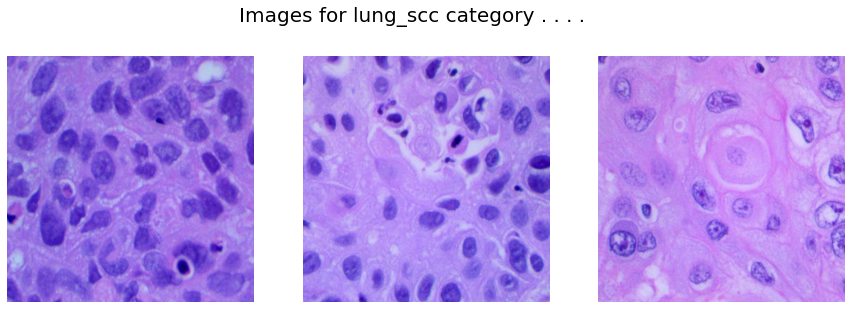

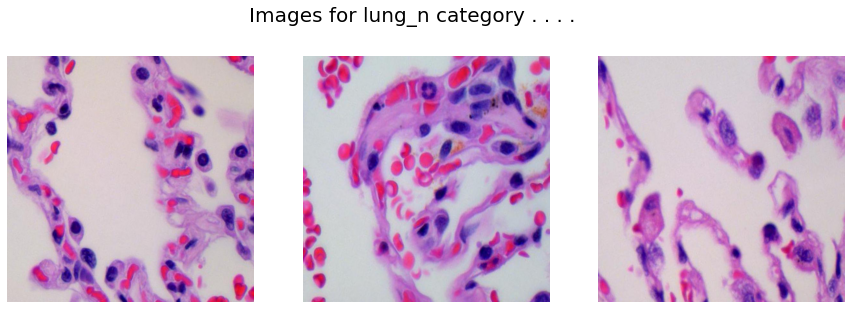

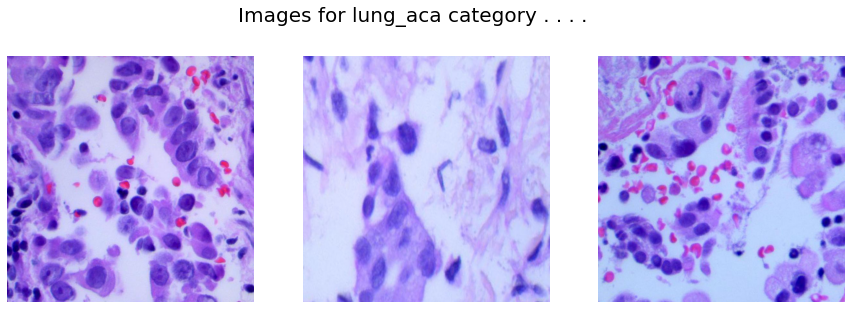

In [ ]:
# Loop over each category in the classes list
for cat in classes:

  # Define the directory where the images for this category are stored
    image_dir = f'{path}/{cat}'

    # Get a list of all the image file names in this directory
    images = os.listdir(image_dir)
 
    # Create category subplots
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
 
    # Loop over the 3 subplots
    for i in range(3):
        # Choose a random image from the list of images for this category
        k = np.random.randint(0, len(images))

        # Use PIL to display images in the subplots
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    # Display plot
    plt.show()

In [ ]:
# Define hyperparameters
IMG_SIZE = 256
SPLIT = 0.15
EPOCHS = 10
BATCH_SIZE = 32

In [ ]:
# Initialize empty lists to store the image data and labels
X = []
Y = []
 
# Loop over each category in the classes list and get a list of all the image file names for this category
for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')
 
  # Loop over each image file in the current category
  for image in images:
    
    # Load the image data using the cv2 module
    img = cv2.imread(image)
     
    # Resize the image to a specific size and add it to the X list
    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    
    # Add the label for this category (i) to the Y list
    Y.append(i)

# Convert the X list to a numpy array
X = np.asarray(X)

# Use Pandas to one-hot encode the Y list (i.e., convert it from a list of integers to a matrix of binary values)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [ ]:
# Split the X and Y arrays into training and validation sets using train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
                                                  test_size = SPLIT,
                                                  random_state = 2022)

# Print the shapes of the resulting arrays to confirm the split was successful
print(X_train.shape, X_val.shape)

(2550, 256, 256, 3) (450, 256, 256, 3)


## Model Development
#### Model Architecture

In [ ]:
# Define a sequential model using Keras
model = keras.models.Sequential([
    
    # Add a convolutional layer with 32 filters, a 5x5 kernel, and ReLU activation
    # Specify the input shape as IMG_SIZE x IMG_SIZE x 3, where 3 is the number of color channels (RGB)
    # Use padding='same' to preserve the input shape after convolution
    layers.Conv2D(filters=32,
                  kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(IMG_SIZE,
                               IMG_SIZE,
                               3),
                  padding='same'),

    # Add a max pooling layer with 2x2 pool size
    layers.MaxPooling2D(2, 2),
 
    # Add another convolutional layer with 64 filters, a 3x3 kernel, and ReLU activation
    layers.Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    # Add another max pooling layer with 2x2 pool size
    layers.MaxPooling2D(2, 2),
 
    # Add a third convolutional layer with 128 filters, a 3x3 kernel, and ReLU activation
    layers.Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),

    # Add a third max pooling layer with 2x2 pool size
    layers.MaxPooling2D(2, 2),
 
    # Flatten the output from the convolutional layers to a 1D array
    layers.Flatten(),
 
    # Add a fully connected layer with 256 units and ReLU activation
    layers.Dense(256, activation='relu'),
 
    # Add batch normalization to normalize the outputs of the previous layer
    layers.BatchNormalization(),
 
    # Add another fully connected layer with 128 units and ReLU activation
    layers.Dense(128, activation='relu'),
 
    # Add dropout to prevent overfitting
    layers.Dropout(0.3),
 
    # Add another batch normalization layer
    layers.BatchNormalization(),
 
    # Add a final fully connected layer
    layers.Dense(3, activation='softmax')
])

In [ ]:
# Compile the model
model.compile(
    optimizer = 'adam', # optimize the cost function by using gradient descent
    loss = 'categorical_crossentropy', # loss function by which we monitor whether the model
    metrics = ['accuracy'] # helps to evaluate the model
)

In [ ]:
# Define a custom callback class that will be called at the end of each epoch
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto \
                      90% so, stopping further training.')
            self.model.stop_training = True
 
# Create an instance of the EarlyStopping callback
es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)
 
# Create an instance of the ReduceLROnPlateau callback
lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

### Model Training

In [ ]:
# Fit the model on the training data
history = model.fit(X_train, Y_train,
                    validation_data = (X_val, Y_val),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1,
                    callbacks = [es, lr, myCallback()])

Epoch 1/10
 6/80 [=>............................] - ETA: 36s - loss: 0.7887 - accuracy: 0.6406

80/80 [==============================] - 44s 521ms/step - loss: 0.5229 - accuracy: 0.7737 - val_loss: 31.7201 - val_accuracy: 0.3156 - lr: 0.0010
Epoch 2/10
80/80 [==============================] - 40s 502ms/step - loss: 0.3945 - accuracy: 0.8247 - val_loss: 51.1073 - val_accuracy: 0.3444 - lr: 0.0010
Epoch 3/10
80/80 [==============================] - 40s 496ms/step - loss: 0.3736 - accuracy: 0.8471 - val_loss: 13.1774 - val_accuracy: 0.3422 - lr: 0.0010
Epoch 4/10
80/80 [==============================] - 40s 501ms/step - loss: 0.2791 - accuracy: 0.8902 - val_loss: 3.2697 - val_accuracy: 0.6556 - lr: 0.0010
Epoch 5/10
80/80 [==============================] - 40s 494ms/step - loss: 0.2439 - accuracy: 0.9078 - val_loss: 1.7818 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 6/10
80/80 [==============================] - 40s 500ms/step - loss: 0.1863 - accuracy: 0.9310 - val_loss: 1.3888 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 7/10
80/80 [==============================] - 40s 496ms/step - los

## Model Evaluation

In [ ]:
# Make predictions on the validation data using the trained model
Y_pred = model.predict(X_val)

# Convert the validation data labels to one-dimensional arrays of their index positions
Y_val = np.argmax(Y_val, axis=1)

# Convert the predicted labels to one-dimensional arrays of their index positions
Y_pred = np.argmax(Y_pred, axis=1)

15/15 [==============================] - 1s 42ms/step


In [ ]:
# Use the scikit-learn `classification_report` function to print a classification report
# based on the predicted and actual labels for the validation data
print(metrics.classification_report(Y_val, Y_pred,
                                    target_names=classes))

              precision    recall  f1-score   support

    lung_scc       0.88      0.69      0.77       155
      lung_n       0.48      1.00      0.65       142
    lung_aca       0.94      0.20      0.33       153

    accuracy                           0.62       450
   macro avg       0.77      0.63      0.59       450
weighted avg       0.77      0.62      0.58       450

